# Energy Grid Stability (regression)

In this notebook I will try and predict weather or not an energy grid is stable or not based on the rection time of participants and the nominal power consumed.

In [1]:
# import packages

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/Users/Stevenkoenemann/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0-alpha0


### Preprocessing data

In [2]:
# read csv file into dataframe

energy = pd.read_csv('energystability.csv')
energy.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860


Now that the data is in the notebook it is time to split the data into a training dataset and a testing dataset. The training dataset will contain 80% of all of the data and is what will be used to train the model. The testing dataset will contain the remaining 20% and is what we will use to validate the model to help make sure that it is generalized enough to be used to make predictions. 

In [3]:
# train/test split

train_dataset = energy.sample(frac=0.8,random_state=0)
test_dataset = energy.drop(train_dataset.index)

The next thing that I have done is taken a look at the overall statistics of the data set to make sure that there are no odd values (like maximums or minimums that do not make sense in our dataset).

In [4]:
train_stats = train_dataset.describe()
train_stats.pop("stab")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
tau1,8000.0,5.252311,2.730528,0.500793,2.896013,5.245520,7.623180,9.999469
tau2,8000.0,5.243871,2.736950,0.501582,2.881897,5.229166,7.603045,9.999837
tau3,8000.0,5.263019,2.740668,0.500788,2.886000,5.271991,7.629343,9.998114
tau4,8000.0,5.257004,2.723285,0.500473,2.918221,5.276222,7.605912,9.999443
p1,8000.0,3.751434,0.750937,1.642860,3.217843,3.752311,4.284141,5.864418
p2,8000.0,-1.249240,0.431270,-1.999891,-1.621116,-1.248988,-0.874082,-0.500108
p3,8000.0,-1.250749,0.434968,-1.999945,-1.632151,-1.249168,-0.872687,-0.500072
p4,8000.0,-1.251445,0.432664,-1.999926,-1.626899,-1.249293,-0.880421,-0.500025
g1,8000.0,0.523358,0.273807,0.050009,0.285511,0.523771,0.759803,0.999846
g2,8000.0,0.526272,0.274012,0.050053,0.289936,0.527113,0.762966,0.999944


Isolating the target value into a different dataframe from the features is the next step that I have taken. 

In [5]:
train_labels = train_dataset.pop('stab')
test_labels = test_dataset.pop('stab')

The last step that needs to be taken before building the actual model is normalizing the data. Normalizing the data is important because we do not want one feature to influence the model more just because the numbers are larger and vice versa. For this dataset the values are all relatively close in value so it is not super important but it is a good habit. 

In [6]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### Building the model

The model that I will build below will be a fairly basic model that consists of two dense hidden layers and a single output layer which will predict the stability of the energy grid. 

In [16]:
def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [17]:
model = build_model()

It is important to check the model to make sure that it is set up the way that you would like it to before training because training can take significant time depending on the size of the data set and how complex the model is. 

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                208       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


The next step is to train the model that we have created. This will be done over 500 epochs and the results will be recorded for evaluation.

In [20]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Once the model is done with its training the next step is to take a look at how well it did. 

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,0.000048,0.005106,0.000048,0.000058,0.005535,0.000058,495
496,0.000048,0.005086,0.000048,0.000055,0.005341,0.000055,496
497,0.000047,0.005065,0.000047,0.000073,0.006258,0.000073,497
498,0.000048,0.005073,0.000048,0.000056,0.005341,0.000056,498
499,0.000047,0.005082,0.000047,0.000081,0.006841,0.000081,499


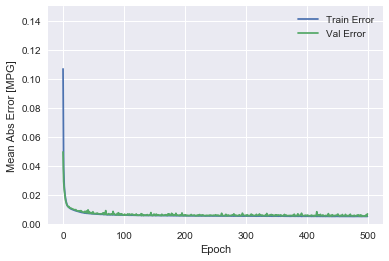

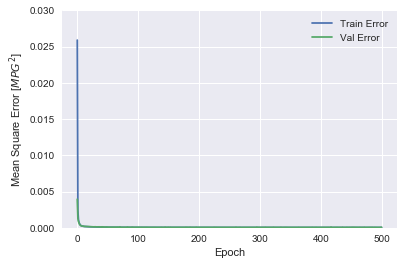

In [29]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.15])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.03])
  plt.legend()
  plt.show()


plot_history(history)

We can see from the table and the two graphs above that the model did quite well. Since the model seems to have trained well, the next thing to do is use the test set to see if the model we built is generalized enough to predict valuse outside of our training set. 

In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

Testing set Mean Abs Error:  0.01 


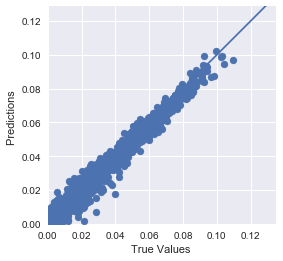

In [15]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

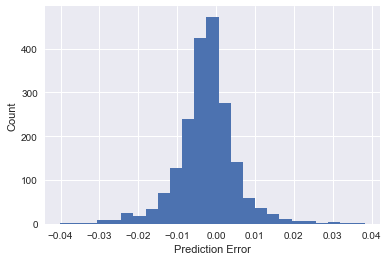

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

The model performed well on the test data in the sense that it can predict valuse accurately and has a normal prediction error. 